## <img src="Imatges/IBM-DataScience.png" width="400" />
<h1><center>Capstone Project</center></h1>
<strong><center>Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto</center></strong>
<h3><center><strong>Part 3</strong></center></h3>
<h3><strong>Author:</strong> Jordi Planas </h3>
<h3>March 2020 </h3>

## Introduction
In this <strong>Part 3</strong> of the assignemnt of week 3, you will find, at the beginning, the two first parts which are necessary for uploading and preparing the basic geographical data on Toronto.
Once we have the geographical coordinates of each postal code, we will use the <strong>explore</strong> function to get the most common venue categories in each neighborhood in the city of Toronto. Then, we will use this information to cluster "neighborhoods" with the <strong>k</strong> means algorithm and show the results in a map.

In [1]:
import pandas as pd
#!pip install wikipedia
import wikipedia as wp


### Fetching Data

In [62]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
try: 
    df = pd.read_html(html)[0]  # Try 2nd table first as most pages contain contents table first
except:
    print("Something went wrong when reading the page")

### Data processing

In [63]:
indexNames = df[df['Borough'] == 'Not assigned' ].index
df.drop(indexNames, axis = 0, inplace = True)
df['Neighborhood'] = df['Neighborhood'].str.replace(' /',',')
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)
df.rename(columns = {'Postal code' : 'Postal Code'}, inplace = True)

## Begining of part 2

### Retrieving the coordinates through the downloaded csv file

In [58]:
import wget

url = 'http://cocl.us/Geospatial_data'
wget.download(url, 'Dades/Geospatial_data.csv')
coordinates = pd.read_csv('Dades/Geospatial_data.csv')

### Merging the two dataframes to get a single one with all the relevant information

In [64]:
df_coor = pd.merge(df, coordinates, how='left', on='Postal Code')
df_coor.loc[]

## Part 3

### Clarification
In parts 1 and 2 of this assignment, the data has been processed as to have the geographical coordinates of postal codes. This has several implications which will affect the interpretation of the results.
* All boroughs except one, are divided into several postal codes, the extreme case being North York divided into 24 postal codes
* In a postal code there might be several Neighborhoods

This means that the results must be interpreted in terms of postal codes not in terms of neighborhoods.
However, there is a further issue to be solved, We don't know the radius of the postal code areas, this means that, if we fetch venues within an arbitrary radius of the location, we may well find some of the following situations:
* The selected radius produce an overlap of two postal code areas and there will be duplicate information in different areas
* The selected radius doesn't reach the limits of the postal code area and there will be missing information

We will try to solve this issue by calculating the max radius of each postal code area. This will still produce some overlaping, but it will be the minimal one.


## Part 3.1 Data processing
### Calculating distances among postal code areas using the library "Geopy"
The method that we are going to apply follow these steps:
1. Get the distribution of the distances from each postal district to the rest
2. By observation of the histogram we see that the neighbouring areas show a first peak in the histogram
3. Thus, we detect the last bin of the histogram as the one with a negative increment
4. Finally we average de edges of the firsts bins to get the average distance with neighbouring areas
5. This distance divided by two will be used as the radius of the venues search request

In [72]:
import geopy.distance

In [315]:
Columns = ['Index', 'Delta']
delta = pd.DataFrame(columns = Columns)
maxIndex = pd.DataFrame(columns=['Postal Code','maxRadius'])

#Loop through geographical coordinates
for i in range (0,len(df_coor['Postal Code'])):
    delta = delta.iloc[0:0]
    dist = []
    for j in range (0,len(df_coor['Postal Code'])):
        coords_1 = [df_coor.iloc[i]['Latitude'], df_coor.iloc[i]['Longitude']]
        coords_2 = [df_coor.iloc[j]['Latitude'], df_coor.iloc[j]['Longitude']]
#Calculate de distances between postal code areas
        dist.append([df_coor.iloc[j]['Postal Code'],geopy.distance.distance(coords_1, coords_2).km])
#Get the histogram of the distances
    hist, bin_edges = np.histogram([row[1] for row in dist], bins = int(max([row[1] for row in dist])))
#Here we are going to detect the max negative increment in the bin frequencies
    for k in range(1,len(hist)):
        if hist[k] != 0 and hist[k-1] != 0:
            delta = delta.append(pd.DataFrame([[k,(hist[k]-hist[k-1])/hist[k-1]]], columns = Columns), ignore_index=True)
#Finally we average the bin edges of the firsts bins
    for l in range(0, len(delta)):
        if delta.iloc[l, 1] < 0:
            maxIndex = maxIndex.append(pd.DataFrame([[df_coor.iloc[i]['Postal Code'], (np.mean(bin_edges[0:1+delta.iloc[l]['Index']]))/2]], columns = ['Postal Code','maxRadius']), ignore_index=True)
            break


In [321]:
maxIndex.sort_values(by=['maxRadius']).head(20)

,Postal Code,maxRadius
92,M5W,0.250995
30,M5H,0.251549
48,M5L,0.251562
20,M5E,0.251883
62,M5N,0.252088
97,M5X,0.252462
42,M5K,0.253296
47,M4L,0.255017
15,M5C,0.256819
100,M7Y,0.259914


#### Now, to have a better idea of the results of this analysis we plot the histogram of the average radius of the postal code areas

(0.0, 30.0)

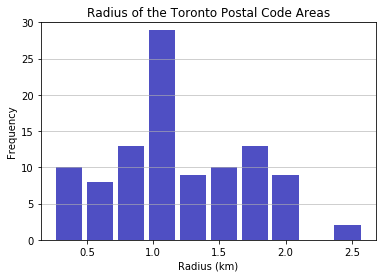

In [316]:
import numpy as np
import matplotlib.pyplot as plt
#int(max([row[1] for row in dist]))
#[row[1] for row in dist]
n, bins, patches = plt.hist(x=maxIndex['maxRadius'], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Radius (km)')
plt.ylabel('Frequency')
plt.title('Radius of the Toronto Postal Code Areas')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)



### Merging data to get a new data frame

In [323]:
df_PC = pd.merge(df_coor, maxIndex, how='left', on='Postal Code')

In [324]:
df_PC.sort_values(by=['maxRadius']).head(20)
#df_PC.loc[df_PC['Postal Code'] == 'M6R']

,Postal Code,Borough,Neighborhood,Latitude,Longitude,maxRadius
92,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,0.250995
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.251549
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0.251562
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0.251883
62,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0.252088
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.252462
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0.253296
47,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0.255017
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.256819
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,0.259914


## Part 3.2 Exploring neighborhoods* in Toronto
\*Just keep in mind that we are working with postal code areas
#### 3.2.1 Importing libraries and writing the function to gather venue info from all neighbourhoods in Toronto

In [299]:
import json # library to handle JSON files
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

In [382]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### 3.2.2 Running the function and checking the results

In [383]:
CLIENT_ID = 'B4MDA5202SPZKSXKPI2HBMBBKZJOGO3JLSJIFSDUB4KAHNRA' # your Foursquare ID
CLIENT_SECRET = '3AWRQK4LEEDBDDBKW5JI1Q5G5DYU00HWR4KRT13VYWVNWUS2' # your Foursquare Secret
VERSION = '20200330' # Foursquare API version
LIMIT = 100
Toronto_venues = getNearbyVenues(names=df_PC['Postal Code'],
                                 latitudes=df_PC['Latitude'],
                                 longitudes=df_PC['Longitude'],
                                 radius = df_PC['maxRadius']*1000 #maxRadius is expressed in km and we want to pass it to the function in meters
                                  )

In [354]:
print(Toronto_venues.shape)
Toronto_venues.head()

(5511, 7)


,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,M3A,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,M3A,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,M3A,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


#### 3.2.3 Analyze each neighborhood

In [356]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postal Code column back to dataframe
#Toronto_onehot.drop(labels=['Postal Code'], axis=1,inplace = True)
Toronto_onehot.insert(0, 'Postal Code', Toronto_venues['Postal Code'])  

Toronto_onehot.head()

,Postal Code,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3.2.4 Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [357]:
Toronto_grouped = Toronto_onehot.groupby('Postal Code').mean().reset_index()
Toronto_grouped

,Postal Code,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.021277,0.000000,0.042553,0.319149
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029412,0.000000,0.029412,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
99,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
100,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.028571,0.000000,0.000000,0.000000,0.000000
101,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


#### 3.2.5 Grouping the 10 top venues in each neighborhood

In [377]:
# first we write a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
#Now, we create a new data frame
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = Toronto_grouped['Postal Code']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Fast Food Restaurant,Gas Station,Zoo,Athletics & Sports,Park,Bus Station,Pizza Place,Spa,Fried Chicken Joint
1,M1C,Burger Joint,Park,Breakfast Spot,Playground,Italian Restaurant,Farm,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1E,Pizza Place,Fast Food Restaurant,Breakfast Spot,Juice Bar,Bank,Coffee Shop,Bar,Supermarket,Liquor Store,Train Station
3,M1G,Pizza Place,Park,Coffee Shop,Indian Restaurant,Pharmacy,Discount Store,Fast Food Restaurant,Supermarket,Burger Joint,Music Store
4,M1H,Coffee Shop,Bakery,Gas Station,Indian Restaurant,Pharmacy,Bank,Grocery Store,German Restaurant,Chinese Restaurant,Convenience Store


## Part 3.3 Clustering analysis
Run *k*-means to cluster neighborhoods into 4 clusters. After a first analysis with 5 clusters we have decided to better group them into 4 clusters
#### 3.3.1 *k*-means modeling

In [378]:
# set number of clusters
kclusters = 4

Toronto_grouped_clustering = Toronto_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 1])

#### 3.3.2 Creating a new data frame with all the relevant data

In [379]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_PC

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

Toronto_merged.head() # check the first columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,maxRadius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.016969,2,Park,Bus Stop,Convenience Store,Pharmacy,Shopping Mall,Caribbean Restaurant,Laundry Service,Tennis Court,Shop & Service,Discount Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.005701,1,Coffee Shop,Portuguese Restaurant,Middle Eastern Restaurant,Men's Store,Lounge,Café,Park,Golf Course,Gym / Fitness Center,Intersection
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.516357,1,Coffee Shop,Pub,Park,Bakery,Mexican Restaurant,Breakfast Spot,Theater,Café,Bank,Thai Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.023193,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Furniture / Home Store,Fried Chicken Joint,Sushi Restaurant,Dessert Shop,Vietnamese Restaurant,Accessories Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.507019,1,Coffee Shop,Burger Joint,Distribution Center,Restaurant,Park,Juice Bar,Diner,Discount Store,Theater,Music Venue


#### 3.3.3 Cluster characterization
##### Cluster 1

In [384]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,maxRadius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Downtown Toronto,0.251883,0,Breakfast Spot,Liquor Store,Restaurant,Zoo Exhibit,Farm,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


This is a cluster with only one area, it is thus a very special cluster which is located in a very special area, at the heart of downtown Toronto. It's probably an area of high standard shopping
##### Cluster 2

In [385]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,maxRadius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1.005701,1,Coffee Shop,Portuguese Restaurant,Middle Eastern Restaurant,Men's Store,Lounge,Café,Park,Golf Course,Gym / Fitness Center,Intersection
2,Downtown Toronto,0.516357,1,Coffee Shop,Pub,Park,Bakery,Mexican Restaurant,Breakfast Spot,Theater,Café,Bank,Thai Restaurant
4,Downtown Toronto,0.507019,1,Coffee Shop,Burger Joint,Distribution Center,Restaurant,Park,Juice Bar,Diner,Discount Store,Theater,Music Venue
9,Downtown Toronto,0.506136,1,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Café,Electronics Store,Thai Restaurant,Theater
12,Scarborough,1.004820,1,Burger Joint,Park,Breakfast Spot,Playground,Italian Restaurant,Farm,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
15,Downtown Toronto,0.256819,1,Japanese Restaurant,Coffee Shop,Restaurant,Gastropub,Italian Restaurant,Middle Eastern Restaurant,Food Truck,Camera Store,Thai Restaurant,BBQ Joint
16,York,0.779393,1,Park,Gastropub,Italian Restaurant,Deli / Bodega,Farmers Market,Coffee Shop,Trail,Field,Playground,Korean Restaurant
19,East Toronto,1.015525,1,Pub,Pizza Place,Coffee Shop,Breakfast Spot,Park,Beach,Japanese Restaurant,Burger Joint,Caribbean Restaurant,Bar
23,East York,1.041515,1,Coffee Shop,Indian Restaurant,Sporting Goods Shop,Grocery Store,Bakery,Sushi Restaurant,Furniture / Home Store,Electronics Store,Restaurant,Bank
24,Downtown Toronto,0.512936,1,Coffee Shop,Italian Restaurant,Burger Joint,Café,Sandwich Place,Japanese Restaurant,Thai Restaurant,Bar,Spa,Salad Place


Cluster 2 is one of the ones that have more occurrences. Tipically describes most of the areas in Toronto city where coffee shops, pubs and restaurants are the most common venues. It quite neatly distinguishes Toronto city from the suburbs. It probably reflects a city area were the main activities are work and leissure.

##### Cluster 3

In [386]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,maxRadius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1.016969,2,Park,Bus Stop,Convenience Store,Pharmacy,Shopping Mall,Caribbean Restaurant,Laundry Service,Tennis Court,Shop & Service,Discount Store
3,North York,1.023193,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Furniture / Home Store,Fried Chicken Joint,Sushi Restaurant,Dessert Shop,Vietnamese Restaurant,Accessories Store
5,Etobicoke,0.764955,2,Pharmacy,Café,Shopping Mall,Bank,Park,Playground,Skating Rink,Grocery Store,Zoo Exhibit,Dry Cleaner
6,Scarborough,2.044506,2,Zoo Exhibit,Fast Food Restaurant,Gas Station,Zoo,Athletics & Sports,Park,Bus Station,Pizza Place,Spa,Fried Chicken Joint
7,North York,1.783467,2,Coffee Shop,Japanese Restaurant,Restaurant,Bank,Pizza Place,Burger Joint,Supermarket,Italian Restaurant,Park,Liquor Store
8,East York,1.292328,2,Fast Food Restaurant,Pizza Place,Coffee Shop,Brewery,Athletics & Sports,Skating Rink,Bakery,Park,Pharmacy,Curling Ice
10,North York,1.270187,2,Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Restaurant,Italian Restaurant,Gas Station,Bank,Furniture / Home Store,Latin American Restaurant
11,Etobicoke,1.502800,2,Sandwich Place,Hotel,Pizza Place,Park,Gym / Fitness Center,Farmers Market,Electronics Store,Bank,Theater,Breakfast Spot
13,North York,1.769588,2,Coffee Shop,Restaurant,Gym,Park,Japanese Restaurant,Middle Eastern Restaurant,Sandwich Place,Italian Restaurant,Clothing Store,Beer Store
14,East York,1.035437,2,Coffee Shop,Pizza Place,Sandwich Place,Skating Rink,Athletics & Sports,Park,Plaza,Liquor Store,Diner,Thai Restaurant


Cluster 3 is the other one with more occurrences. Most of the areas in cluster 3 are in the outskirts of Toronto and the venues are motly related to shopping and services. It probably reflects these neighborhoods were people live.

##### Cluster 4

In [387]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,maxRadius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,0.252088,3,Health & Beauty Service,Farmers Market,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant


Again, Cluster 4 is a very special one, it has only one neighborhood which is Central Toronto which is located right at the heart of the boundary between cluster 2 and cluster 3. It probably reflects the area were people in residential neighborhoods (belonging to cluster3) go for special shoping and leisure. 

## Part 3.4 Visualization

In [380]:
#Import libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

# Toronto geographical coordinates
latitude = 43.7305612
longitude = -79.3580544

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
print(len(ys))
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Postal Code'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

4
